In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

circuits = pd.read_csv("circuits.csv")
constructor = pd.read_csv("constructors.csv")
constructor_results = pd.read_csv("constructor_results.csv")
constructor_standings = pd.read_csv("constructor_standings.csv")
driver_standings = pd.read_csv("driver_standings.csv")
drivers = pd.read_csv("drivers.csv")
lap_times = pd.read_csv("lap_times.csv")
pit_stops = pd.read_csv("pit_stops.csv")
qualifying = pd.read_csv("qualifying.csv")
races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
seasons = pd.read_csv("seasons.csv")
sprint_results = pd.read_csv("sprint_results.csv")
status = pd.read_csv("status.csv")

**Creating clusters using similarites between racedrivers (strategy)**

Average finishing position

In [40]:
finishing_position = results.groupby('driverId')['positionOrder'].mean().rename('avg_finish')
finishing_position

driverId
1       5.019663
2      10.722826
3       8.252427
4       8.492574
5      13.285714
         ...    
858    16.333333
859    12.909091
860     9.666667
861    13.555556
862    15.000000
Name: avg_finish, Length: 861, dtype: float64

Average Grid Positions

In [41]:
grid_position = results.groupby('driverId')['grid'].mean().rename('avg_grid')
grid_position

driverId
1       4.300562
2      11.336957
3       6.902913
4       8.579208
5      13.741071
         ...    
858    16.388889
859    13.454545
860    12.000000
861    13.777778
862    17.000000
Name: avg_grid, Length: 861, dtype: float64

Positions gained (grid - position order)

In [42]:
results['positions_gained'] = results['grid'] - results['positionOrder']
positions_gained = results.groupby('driverId')['positions_gained'].mean().rename('avg_positions_gained')

percentage rate of races finished =  races -  Did Not Finish = DNFs / races

In [43]:
dnfs = results[results['statusId'] != 1].groupby('driverId').size()
races = results.groupby('driverId').size()
finish_rate = ((races - dnfs) / races).rename('finish_rate').fillna(0)

made a data frame for the finishing positon, grid position, positions gained and finish rate of each driver (driver_stats)
theyre gonna be grouped into clusters 

Aggressive Drivers

Consistent Qualifiers

Risky Drivers

Conservative Finishers

In [44]:
 
driver_stats = pd.concat([finishing_position, grid_position, positions_gained, finish_rate], axis=1).dropna()
driver_stats = driver_stats.merge(drivers[['driverId', 'surname']], on='driverId', how='left')
driver_stats

,driverId,avg_finish,avg_grid,avg_positions_gained,finish_rate,surname
0,1,5.019663,4.300562,-0.719101,0.876404,Hamilton
1,2,10.722826,11.336957,0.614130,0.358696,Heidfeld
2,3,8.252427,6.902913,-1.349515,0.703883,Rosberg
3,4,8.492574,8.579208,0.086634,0.646040,Alonso
4,5,13.285714,13.741071,0.455357,0.348214,Kovalainen
...,...,...,...,...,...,...
856,858,16.333333,16.388889,0.055556,0.333333,Sargeant
857,859,12.909091,13.454545,0.545455,0.636364,Lawson
858,860,9.666667,12.000000,2.333333,0.000000,Bearman
859,861,13.555556,13.777778,0.222222,0.444444,Colapinto


In [45]:

x = driver_stats[['avg_finish', 'avg_grid', 'avg_positions_gained', 'finish_rate']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [46]:
x

,avg_finish,avg_grid,avg_positions_gained,finish_rate
0,5.019663,4.300562,-0.719101,0.876404
1,10.722826,11.336957,0.614130,0.358696
2,8.252427,6.902913,-1.349515,0.703883
3,8.492574,8.579208,0.086634,0.646040
4,13.285714,13.741071,0.455357,0.348214
...,...,...,...,...
856,16.333333,16.388889,0.055556,0.333333
857,12.909091,13.454545,0.545455,0.636364
858,9.666667,12.000000,2.333333,0.000000
859,13.555556,13.777778,0.222222,0.444444


In [51]:
cluster_names = {
    0: "Conservative Finishers",
    1: "Consistent Qualifiers",
    2: "Aggressive Drivers",
    3: "Risky Drivers"
}

In [53]:
kmeans = KMeans(n_clusters=4, random_state=42)
driver_stats['cluster'] = kmeans.fit_predict(x_scaled)
driver_stats['cluster_label'] = driver_stats['cluster'].map(cluster_names)


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



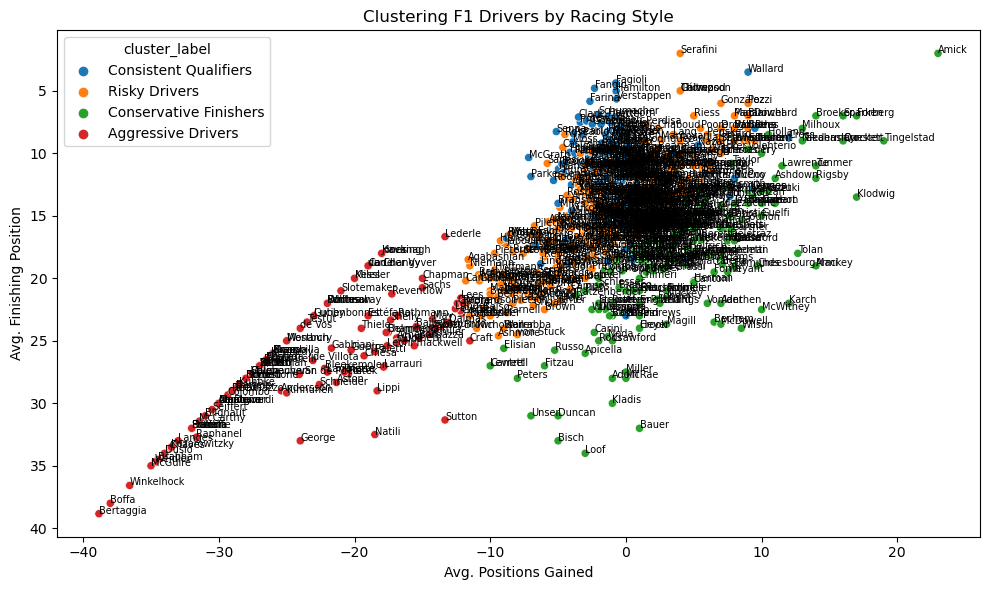

In [58]:
plt.figure(figsize=(10, 6))
top_labeled = driver_stats.groupby('cluster_label').apply(lambda x: x.nsmallest(5, 'avg_finish')).reset_index(drop=True)
sns.scatterplot(data=driver_stats, x='avg_positions_gained', y='avg_finish', hue='cluster_label', palette='tab10')
for _, row in driver_stats.iterrows():
    plt.text(row['avg_positions_gained'], row['avg_finish'], row['surname'], fontsize=7)
plt.title('Clustering F1 Drivers by Racing Style')
plt.xlabel('Avg. Positions Gained')
plt.ylabel('Avg. Finishing Position')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This is way too messy, so instead ill plot the top 5 drivers in each style of racing

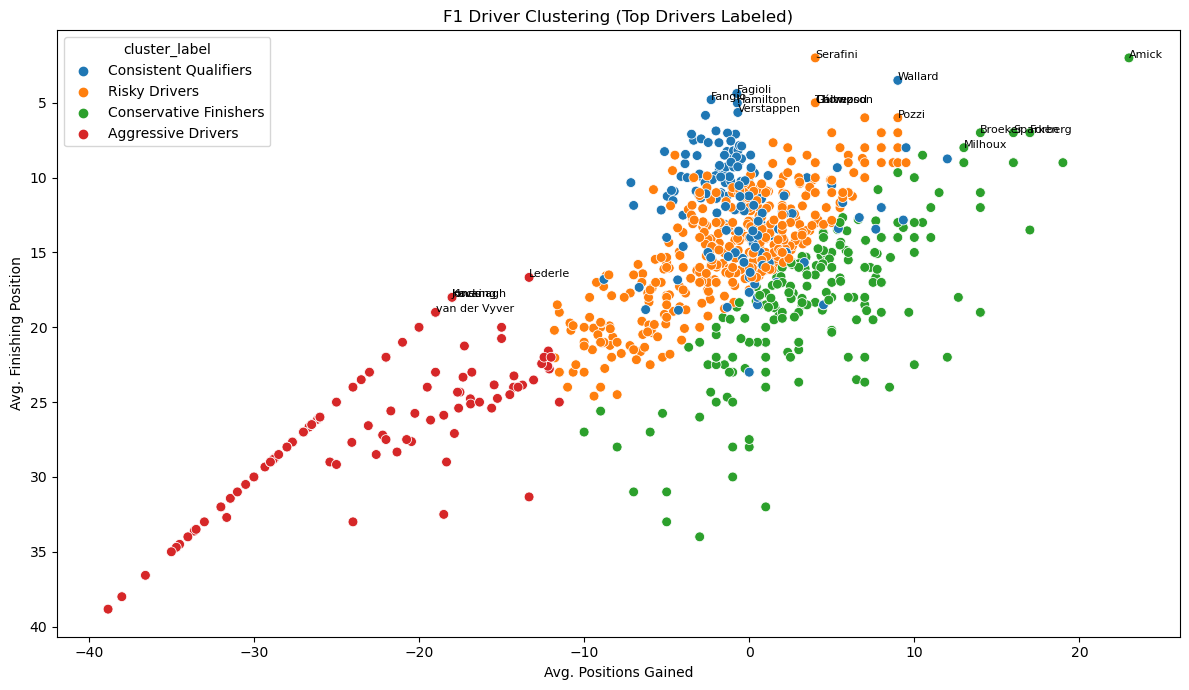

In [59]:
top_labeled = driver_stats.groupby('cluster').apply(lambda x: x.nsmallest(5, 'avg_finish')).reset_index(drop=True)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=driver_stats, x='avg_positions_gained', y='avg_finish', hue='cluster_label', palette='tab10', s=50)

# Only label top drivers
for _, row in top_labeled.iterrows():
    plt.text(row['avg_positions_gained'], row['avg_finish'], row['surname'], fontsize=8)

plt.gca().invert_yaxis()
plt.title("F1 Driver Clustering (Top Drivers Labeled)")
plt.xlabel("Avg. Positions Gained")
plt.ylabel("Avg. Finishing Position")
plt.tight_layout()
plt.show()

Or using plotly, we cna plot an interactive map like in Tableau

In [50]:
fig = px.scatter(
    driver_stats,
    x='avg_positions_gained',
    y='avg_finish',
    color='cluster',
    hover_name='surname',
    title="F1 Driver Clustering by Racing Style",
    labels={"avg_positions_gained": "Avg. Positions Gained", "avg_finish": "Avg. Finishing Position"}
)
fig.update_yaxes(autorange='reversed')  # Higher up = better
fig.show()